# AWS Re:Invent  Autogluon Workshop
### This workshop will demonstrate a machine learning problem solved by autogluon.
* The problem we want to solve in this tutorial is Shopee clothes labeling. The problem is exctracted from [this kaggle competition](https://www.kaggle.com/competitions/shopee-product-matching/leaderboard)
* Use the documentation of autogluon and the different tutorials [here](https://auto.gluon.ai/stable/index.html).

In [ ]:
# installation of needed librairies.
!pip install -U pip
!pip install -U setuptools wheel

# Install the proper version of PyTorch following https://pytorch.org/get-started/locally/
!pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchtext==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu113
#!pip3 install "mxnet_cu101<2.0.0, >=1.7.0"
#!pip3 install "mxnet-cu102<2.0.0"
#!pip3 install "gluoncv>=0.5.0,<0.9.0"
!pip install -U llvmlite --ignore-installed autogluon

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 952 kB 28.5 MB/s            
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.6.0.post20210108
    Uninstalling setuptools-49.6.0.post20210108:
      Successfully uninstalled setuptools-49.6.0.post20210108
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://download.pytorch.org/whl/cu113
ERROR: Could not find a version that satisfies the requirement torch==1.12.0+cu113 (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.

In [ ]:
#!conda install -c anaconda cudatoolkit cudnn -y

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
print(torch.version.cuda)

In [ ]:
# import autogluon tools.
import autogluon
import autogluon.core as ag
from autogluon.vision import ImageDataset, ImagePredictor

import pandas as pd

In [37]:
print('train #', len(train_dataset), 'test #', len(test_dataset))
train_dataset.head()

train # 800 test # 80


image  label
0  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
1  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
2  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
3  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
4  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0

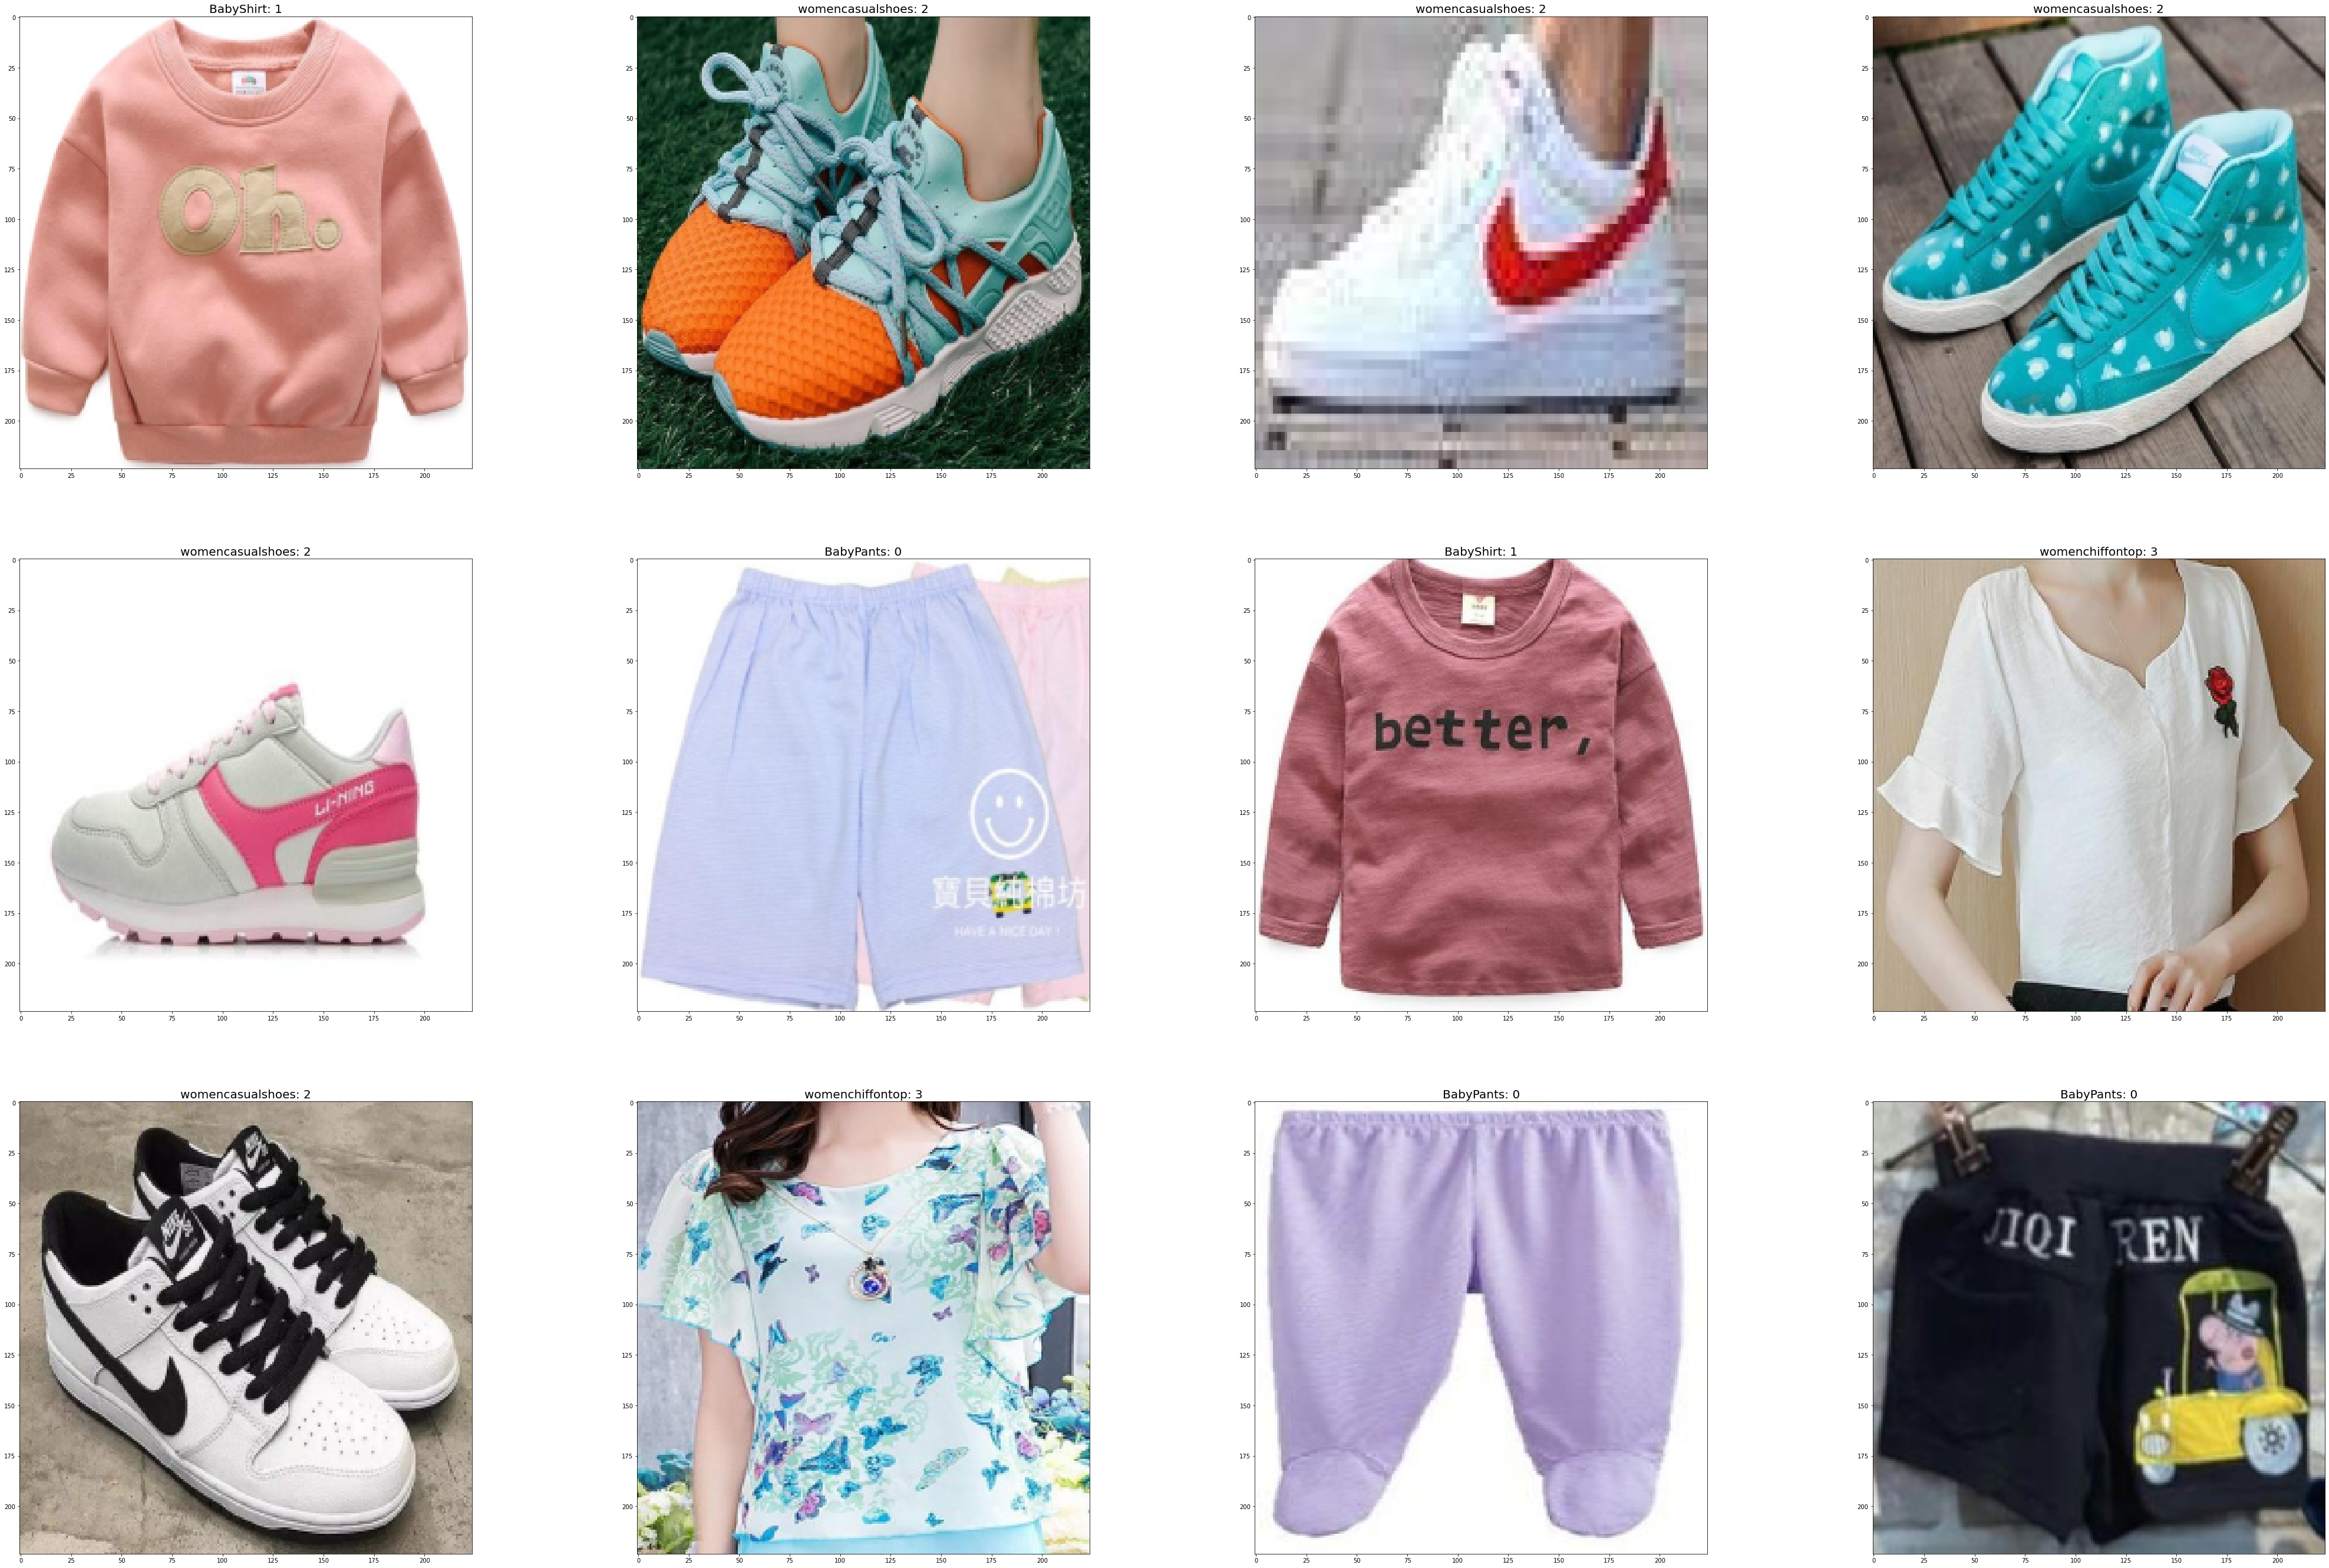

In [38]:
train_dataset.sample(frac=1).iloc[:12].show_images()

### Labels
* 0 Baby Pants
* 1 Baby Shirt
* 2 Women Shoes
* 3 Women Top

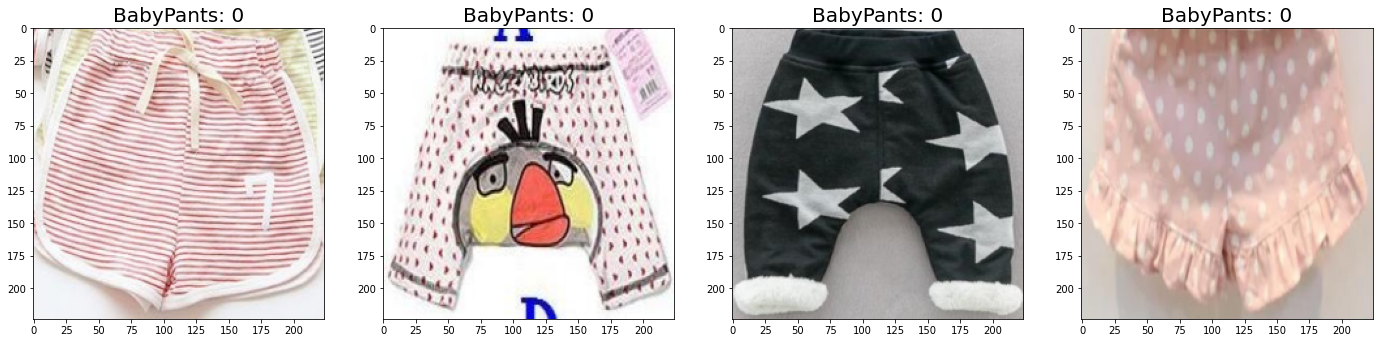

In [39]:
train_dataset.loc[train_dataset['label']==0].iloc[:4].show_images()

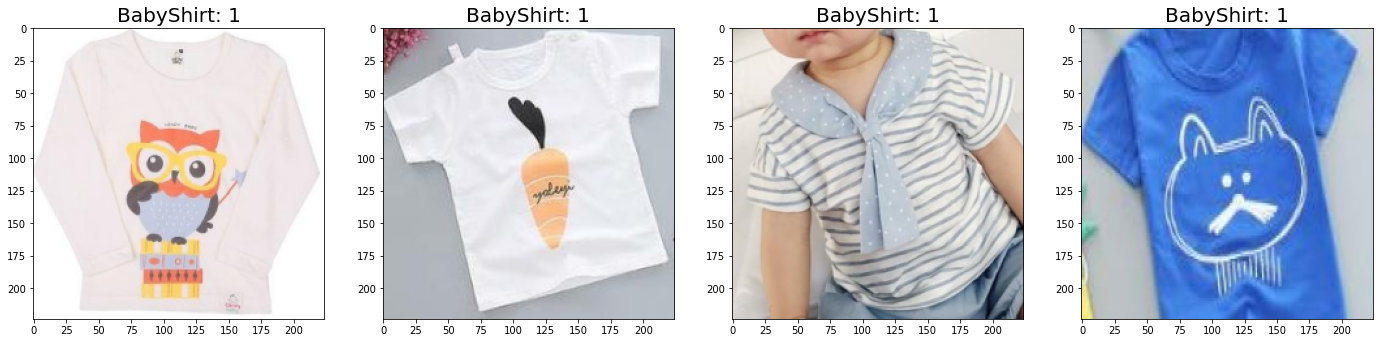

In [40]:
train_dataset.loc[train_dataset['label']==1].iloc[:4].show_images()

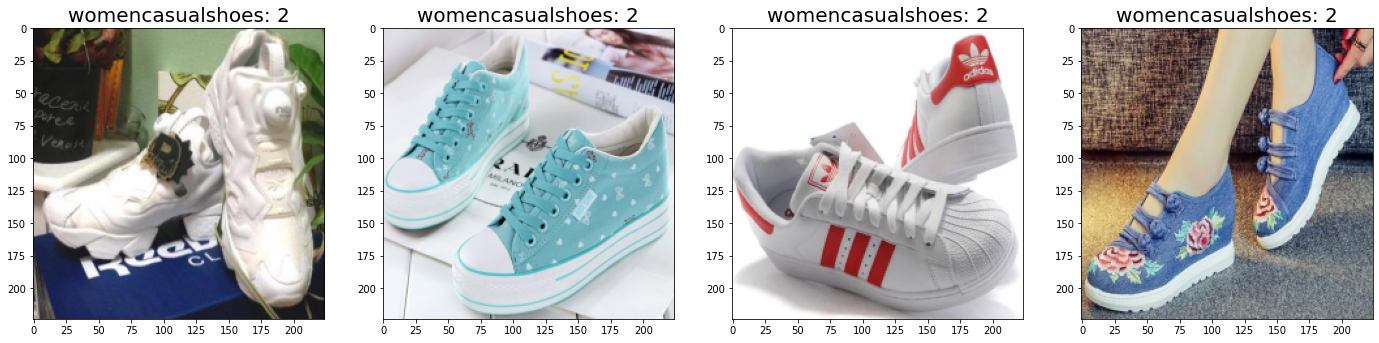

In [41]:
train_dataset.loc[train_dataset['label']==2].iloc[:4].show_images()

In [42]:
train_dataset.loc[train_dataset['label']==3].iloc[:4].show_images()

### Let's use the default config and take a time limit of 5 min.

In [43]:
predictor = ImagePredictor()
predictor.fit(train_dataset, time_limit=5*60)  

ImagePredictor sets accuracy as default eval_metric for classification problems.
Reset labels to [0, 1, 2, 3]
Randomly split train_data into train[720]/validation[80] splits.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting fit without HPO
modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != resnet50
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 15
root.train.early_stop_max_value 1.0 != inf
root.misc.seed       42 != 690
}
Saved config to /home/ec2-user/SageMaker/77432c6a/.trial_0/config.yaml
Model resnet50 created, param count:                                         23516228
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
[Epoch 0] training: accuracy=0.248611
[Epoch 0] speed: 89 samples/sec	time cost: 7.858701
[Epoch 0] validation: top1=0.212500 top5=1.0

### The default model is resnet50, with the best config printed just above.

In [44]:
fit_result = predictor.fit_summary()
print('Top-1 train acc: %.3f, val acc: %.3f' %(fit_result['train_acc'], fit_result['valid_acc']))

Top-1 train acc: 0.781, val acc: 0.912


In [45]:
image_index = 0
image_path = test_dataset.iloc[image_index]['image']
result = predictor.predict(image_path)
print(result)

0    1
Name: label, dtype: int64


### let's have look to test subsample.

In [46]:
test_sample = test_dataset.sample(frac=1).iloc[:4]
test_sample.show_images()

In [47]:
bulk_result = predictor.predict(test_sample)

In [48]:
bulk_result

6     0
64    3
48    2
76    3
Name: label, dtype: int64

In [49]:
test_sample.label

6     0
64    3
48    2
76    3
Name: label, dtype: int64

## Let's try specific models

In [ ]:
ImagePredictor.list_models()

In [51]:
model = ag.Categorical(['resnet18_v1b', 'mobilenetv3_small']) #'vgg19',,'mobilenetv3_small_100','inception_v3'

In [52]:
batch_size = 16
lr = ag.Categorical(1e-2, 1e-3)

In [54]:
hyperparameters={ 'batch_size': batch_size, 'lr': lr} #'model': model,
predictor = ImagePredictor()
predictor.fit(train_dataset,
              time_limit=20*60, 
              hyperparameters=hyperparameters,
              #hyperparameter_tune_kwargs={'num_trials': 2}
             )
print('Top-1 val acc: %.3f' % predictor.fit_summary()['valid_acc'])

ImagePredictor sets accuracy as default eval_metric for classification problems.
Reset labels to [0, 1, 2, 3]
Randomly split train_data into train[720]/validation[80] splits.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting fit without HPO
modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != resnet50
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 15
root.train.early_stop_max_value 1.0 != inf
root.misc.seed       42 != 260
}
Saved config to /home/ec2-user/SageMaker/468319a2/.trial_0/config.yaml
Model resnet50 created, param count:                                         23516228
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
[Epoch 0] training: accuracy=0.234722
[Epoch 0] speed: 86 samples/sec	time cost: 8.131279
[Epoch 0] validation: top1=0.262500 top5=1.0

Top-1 val acc: 0.912


In [55]:
results = predictor.evaluate(test_dataset)
print('Test acc on hold-out data:', results)

[Epoch 14] validation: top1=0.862500 top5=1.000000


Test acc on hold-out data: {'loss': 0.4466578006744385, 'top1': 0.8625, 'top5': 1.0}


In [58]:
test_sample = test_dataset.sample(frac=1).iloc[:4]
test_sample.show_images()

In [59]:
bulk_result = predictor.predict(test_sample)
bulk_result

50    2
5     0
68    1
15    0
Name: label, dtype: int64

In [60]:
test_sample.label

50    2
5     0
68    3
15    0
Name: label, dtype: int64

### Let's see the result with more training time

In [ ]:
hyperparameters={'model': model, 'batch_size': batch_size, 'lr': lr}

predictor = ImagePredictor()
predictor.fit(train_dataset,
              time_limit=2*60*60, 
              hyperparameters=hyperparameters
             )
print('Top-1 val acc: %.3f' % predictor.fit_summary()['valid_acc'])

In [61]:
results = predictor.evaluate(test_dataset)
print('Test acc on hold-out data:', results)

[Epoch 14] validation: top1=0.862500 top5=1.000000


Test acc on hold-out data: {'loss': 0.4466578006744385, 'top1': 0.8625, 'top5': 1.0}


In [ ]:
test_dataset.iloc[10:14].show_images()

In [ ]:
bulk_result = predictor.predict(test_dataset.iloc[10:14])
bulk_result